Initial tests

In [3]:
import pandas as pd
import transformers
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import torch.nn.functional as F

In [15]:
# mount drive to save stuff
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# will check and use MPS if available, otherwise CUDA, otherwise CPU
# mps is super fast mac thing
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA (GPU) - {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using device: CPU")

Using device: CUDA (GPU) - NVIDIA A100-SXM4-40GB


In [1]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
# For downloading entire datasets, install the kaggle API client:
!pip install kaggle

import kagglehub
from kagglehub import KaggleDatasetAdapter

# --------- Run once ---------
# 1. Go to your Kaggle profile: https://www.kaggle.com/<your-username>/account
# 2. Under 'API', click 'Create New API Token' to download `kaggle.json`.
# 3. Upload `kaggle.json` to your Colab environment (e.g., File -> Upload to session storage).
# 4. Run the following commands in a separate cell or uncomment and run them here:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# -----------------------------------------------------

import kaggle

# Download the entire dataset to a local directory and unzip it
dataset_name = "ashery/chexpert"
download_path = "./CheXpert-v1.0-small"
kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)

print(f"Dataset '{dataset_name}' downloaded to: {download_path}")
print("Files in the downloaded dataset:")
!ls -F {download_path}

Dataset URL: https://www.kaggle.com/datasets/ashery/chexpert
Dataset 'ashery/chexpert' downloaded to: ./CheXpert-v1.0-small
Files in the downloaded dataset:
train/	train.csv  valid/  valid.csv


In [5]:
# Load in data and then use only 25% for training and validation
train_full = pd.read_csv("/content/CheXpert-v1.0-small/train.csv")
val_full = pd.read_csv("/content/CheXpert-v1.0-small/valid.csv")
train_subset = train_full.sample(frac=0.25, random_state=42)
val_subset = val_full.sample(frac=0.25, random_state=42)

In [ ]:
train_full.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [6]:
# AP/PA is a view position column, whether Xray facing front or back
# ignoring for now, but maybe we want to keep in the future??
train_subset = train_subset.drop("AP/PA", axis=1)
val_subset = val_subset.drop("AP/PA", axis=1)

In [7]:
train_subset = train_subset.fillna(0)
val_subset = val_subset.fillna(0)

Encoder Classes

### Text Encoder

In [8]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained(
            "bert-base-uncased",
            output_hidden_states=True,
        )
        self.linear = nn.Linear(768, embed_dim)

    def forward(self, token_ids, attention_masks):
        outputs = self.bert(token_ids, attention_mask=attention_masks)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings = self.linear(cls_embeddings)
        # normalizing because we need to compare with image embeddings later
        # for the contrastive similarity
        embeddings = F.normalize(embeddings, p=2, dim=-1, eps=1e-6)
        return embeddings

### Image Encoder

In [9]:
# Use the torchvision's implementation of ResNeXt, but add FC layer to generate 512d embedding.
class VisionEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        in_dim = resnet.fc.in_features
        self.proj = nn.Linear(in_dim, embed_dim)

    def forward(self, x):
        features = self.backbone(x)
        features = features.squeeze(-1).squeeze(-1)
        z = self.proj(features)
        # convert to unit vectors for cosine similarity later
        z = F.normalize(z, p=2, dim=-1, eps=1e-6)
        return z

### Dataset

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        df = df.reset_index(drop=True) # Reset index to ensure 0-based indexing
        # Text stuff
        self.text_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.reports = df.apply(
            generate_report, axis=1
        )  # Maybe move generate report to inside the dataset idk

        # Vision stuff?
        self.images = df["Path"]
        self.transform = transforms.Compose(
            [
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ]
        )

    def __len__(self):
        return len(self.reports)  # This could work or we could do another way

    def __getitem__(self, idx):
        # Text part
        report = self.reports[idx]
        encoder = self.text_tokenizer.encode_plus(
            report,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # Vision part
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(image)

        return {
            "token_ids": encoder["input_ids"],
            "attention_masks": encoder["attention_mask"],
            "image_tensor": img_tensor,
        }  # Is vision part correct?

Samples come in as dataframe and we put in dataset. For each sample, we can then return inputs for text encoder (token ids & attention masks) & for vision encoder (tensor of pixels). We pass relevant inputs to text encoder and vision encoder, get embeddings for that sample. Then blah blah

Training Loop

In [11]:
def generate_report(row):
    labels = row.iloc[4:]
    findings_list = list(labels[labels == 1].index)
    findings = ", ".join(findings_list)
    return f"X-Ray report findings: {findings}"

In [ ]:
# Create train & val datasets
train_dataset = CustomDataset(train_subset)
val_dataset = CustomDataset(val_subset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### Contrastive Loss

# image_encoder - ResNet or Vision Transformer
# text_encoder - CBOW or Text Transformer
# I[n, h, w, c] - minibatch of aligned images
K: n is batch size, h,w is height width, c is number of channels (3 for RGB)

# T[n, l] - minibatch of aligned texts
K: n is batch size, l is sequence length (number of tokens)

K: aligned means that they are paired up

# W_i[d_i, d_e] - learned proj of image to embed
# W_t[d_t, d_e] - learned proj of text to embed
# t - learned temperature parameter

# extract feature representations of each modality
I_f = image_encoder(I) #[n, d_i]
this happens in vision_enc
K: get features from resnet

T_f = text_encoder(T) #[n, d_t]
this happens in text_enc
K: get features from bert

# joint multimodal embedding [n, d_e]
K: this is projecting to joint embedding space
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)

# scaled pairwise cosine similarities [n, n]
logits = np.dot(I_e, T_e.T) * np.exp(t) #K: scale by temperature


# symmetric loss function
labels = np.arange(n) #K: correct match is on the diagonal
# K: now we compute symmetric loss
loss_i = cross_entropy_loss(logits, labels, axis=0) #K: image to text
loss_t = cross_entropy_loss(logits, labels, axis=1) #K: text to image
# K: now average in both directions
loss = (loss_i + loss_t)/2

In [ ]:
# a lot of the steps from the pseudo code are already done in other places!! which is lit
# I_f, T_f, I_e, T_e are all done in other places
def contrastive_loss(image_embeddings, text_embeddings, temperature=0.07):
    # we can make the t a fixed parameter but most CLIP reproductions make it fixed
    # so just keeping it as argument for now

    batch_size = image_embeddings.shape[0]  # called n in the pseudo code

    # we already have normalized embeddings, so we can skip to cosine similarity part of pseudo code
    # "scaled pairwise cosine similarities [n, n]"
    # dividing by temperature to scale the logits
    logits = torch.matmul(image_embeddings, text_embeddings.T) / temperature
    # now "symmetric loss function"
    labels = torch.arange(batch_size, device=image_embeddings.device)
    loss_img_to_text = F.cross_entropy(logits, labels)
    loss_text_to_img = F.cross_entropy(logits.T, labels)

    # average loss in both directions
    loss = (loss_img_to_text + loss_text_to_img) / 2

    return loss

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

SAVE_PATH = "/content/drive/MyDrive/models/vision_text_clip/"

os.makedirs(SAVE_PATH, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =========================
# Setup
# =========================
lr = 1e-4
temperature = 0.07
max_epoch_number = 3
test_freq = 200            # validation frequency
ckpt_freq = 200            # checkpoint frequency (iterations)

# Initialize models
text_enc = TextEncoder(embed_dim=512).to(device)
vision_enc = VisionEncoder(embed_dim=512).to(device)

# Optimizer
all_parameters = list(text_enc.parameters()) + list(vision_enc.parameters())
optimizer = torch.optim.Adam(all_parameters, lr=lr)

# =========================
# Mixed Precision Setup
# =========================
scaler = torch.cuda.amp.GradScaler()

iteration = 0
for epoch in range(max_epoch_number):
    text_enc.train()
    vision_enc.train()
    batch_losses = []

    for batch in train_loader:
        images = batch["image_tensor"].to(device)
        token_ids = batch["token_ids"].squeeze(1).to(device)
        attention_masks = batch["attention_masks"].squeeze(1).to(device)

        optimizer.zero_grad()

        # =========================
        # Forward with mixed precision
        # =========================
        with torch.cuda.amp.autocast():
            image_embeddings = vision_enc(images)
            text_embeddings = text_enc(token_ids, attention_masks)

            if torch.isnan(image_embeddings).any():
                print("NaN in image_embeddings"); break
            if torch.isnan(text_embeddings).any():
                print("NaN in text_embeddings"); break

            loss = contrastive_loss(image_embeddings, text_embeddings, temperature)

            if torch.isnan(loss).any():
                print("NaN in loss"); break

        # =========================
        # Backward with gradient scaling
        # =========================
        batch_loss_value = loss.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_losses.append(batch_loss_value)

        # =========================
        # Validation
        # =========================
        if iteration % test_freq == 0:
            text_enc.eval()
            vision_enc.eval()
            val_losses = []

            with torch.no_grad():
                for batch_val in val_loader:
                    val_images = batch_val["image_tensor"].to(device)
                    val_token_ids = batch_val["token_ids"].squeeze(1).to(device)
                    val_attention_masks = batch_val["attention_masks"].squeeze(1).to(device)

                    # Mixed precision for validation too
                    with torch.cuda.amp.autocast():
                        val_img_embeds = vision_enc(val_images)
                        val_txt_embeds = text_enc(val_token_ids, val_attention_masks)
                        val_loss = contrastive_loss(val_img_embeds, val_txt_embeds, temperature)

                    val_losses.append(val_loss.item())

            avg_val_loss = float(np.mean(val_losses))
            print(f"epoch:{epoch+1:2d} iter:{iteration:4d} val loss:{avg_val_loss:.3f}")

            text_enc.train()
            vision_enc.train()

        # =========================
        # Periodic checkpoint
        # =========================
        if iteration % ckpt_freq == 0:
            ckpt_path = os.path.join(SAVE_PATH, f"checkpoint_iter_{iteration}.pt")
            torch.save(
                {
                    "epoch": epoch,
                    "iteration": iteration,
                    "text_enc": text_enc.state_dict(),
                    "vision_enc": vision_enc.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scaler": scaler.state_dict(),  # Save scaler state
                    "train_loss": float(batch_loss_value),
                },
                ckpt_path,
            )
            print(f"Checkpoint saved to {ckpt_path}")

        iteration += 1

    train_loss = float(np.mean(batch_losses))
    print(f"epoch:{epoch+1:2d} iter:{iteration:4d} train loss:{train_loss:.3f}\n")

# =========================
# Final checkpoint
# =========================
final_path = os.path.join(SAVE_PATH, "final_checkpoint.pt")
torch.save(
    {
        "epoch": epoch,
        "iteration": iteration,
        "text_enc": text_enc.state_dict(),
        "vision_enc": vision_enc.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict(),  # Save scaler state
        "train_loss": train_loss,
    },
    final_path,
)
print(f"Final checkpoint saved to {final_path}")

/tmp/ipython-input-446925222.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-446925222.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-446925222.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


epoch: 1 iter:   0 val loss:2.655
Checkpoint saved to /content/drive/MyDrive/models/vision_text_clip/checkpoint_iter_0.pt
epoch: 1 iter: 200 val loss:2.352
Checkpoint saved to /content/drive/MyDrive/models/vision_text_clip/checkpoint_iter_200.pt
epoch: 1 iter: 400 val loss:2.338
Checkpoint saved to /content/drive/MyDrive/models/vision_text_clip/checkpoint_iter_400.pt
epoch: 1 iter: 600 val loss:2.327
Checkpoint saved to /content/drive/MyDrive/models/vision_text_clip/checkpoint_iter_600.pt
epoch: 1 iter: 800 val loss:2.335
Checkpoint saved to /content/drive/MyDrive/models/vision_text_clip/checkpoint_iter_800.pt
epoch: 1 iter:1000 val loss:2.466
Checkpoint saved to /content/drive/MyDrive/models/vision_text_clip/checkpoint_iter_1000.pt
epoch: 1 iter:1200 val loss:2.542
Checkpoint saved to /content/drive/MyDrive/models/vision_text_clip/checkpoint_iter_1200.pt
epoch: 1 iter:1400 val loss:2.474
Checkpoint saved to /content/drive/MyDrive/models/vision_text_clip/checkpoint_iter_1400.pt
epoch: 

In [ ]:
print("Trainable parameters (text):", sum(p.numel() for p in text_enc.parameters() if p.requires_grad))
print("Trainable parameters (vision):", sum(p.numel() for p in vision_enc.parameters() if p.requires_grad))


find: ‘/content/drive’: No such file or directory


### GAN

In [12]:
# new dataset for image size


class CustomGANDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        df = df.reset_index(drop=True) # Reset index to ensure 0-based indexing
        # Text stuff
        self.text_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.reports = df.apply(
            generate_report, axis=1
        )  # Maybe move generate report to inside the dataset idk

        # Vision stuff?
        self.images = df["Path"]
        self.transform = transforms.Compose(
        [
        transforms.Resize((128, 128)),          # changed from 256 to 128
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
          ),  # maps [0,1] -> [-1,1]
        ]
        )

    def __len__(self):
        return len(self.reports)  # This could work or we could do another way

    def __getitem__(self, idx):
        # Text part
        report = self.reports[idx]
        encoder = self.text_tokenizer.encode_plus(
            report,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # Vision part
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(image)

        return {
            "token_ids": encoder["input_ids"],
            "attention_masks": encoder["attention_mask"],
            "image_tensor": img_tensor,
        }  # Is vision part correct?

In [13]:
# Create train & val datasets
train_gandataset = CustomGANDataset(train_subset)
val_gandataset = CustomGANDataset(val_subset)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
# Create data loaders
train_ganloader = DataLoader(train_gandataset, batch_size=16, shuffle=False)
val_ganloader = DataLoader(val_gandataset, batch_size=16, shuffle=False)

In [18]:
# freezing text encoder
state = torch.load("final_checkpoint.pt", map_location=device)
text_enc.load_state_dict(state["text_enc"])
text_enc.eval()
for p in text_enc.parameters():
    p.requires_grad = False

FileNotFoundError: [Errno 2] No such file or directory: 'final_checkpoint.pt'

In [19]:
class Generator(nn.Module):
    def __init__(self, z_dim=128, t_dim=512):
        super().__init__()
        in_dim = z_dim + t_dim  # 640

        # start from 8x8
        self.fc = nn.Linear(in_dim, 512 * 8 * 8)

        self.main = nn.Sequential(
            # 512 x 8 x 8 -> 256 x 16 x 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 256 x 16 x 16 -> 128 x 32 x 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 128 x 32 x 32 -> 64 x 64 x 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 64 x 64 x 64 -> 3 x 128 x 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),   # output in [-1, 1]
        )

    def forward(self, z_noise, e_text):
        cond = torch.cat([z_noise, e_text], dim=-1)      # [B, 640]
        x = self.fc(cond)                                # [B, 512*8*8]
        x = x.view(x.size(0), 512, 8, 8)                 # [B, 512, 8, 8]
        img = self.main(x)                               # [B, 3, 128, 128]
        return img


In [20]:
class Discriminator(nn.Module):
    def __init__(self, t_dim=512):
        super().__init__()
        self.img_net = nn.Sequential(
            # 3 x 128 x 128 -> 64 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 x 64 x 64 -> 128 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 x 32 x 32 -> 256 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 256 x 16 x 16 -> 512 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # final feature map: [B, 512, 8, 8]
        self.fc_img = nn.Linear(512 * 8 * 8, 512)
        self.fc_joint = nn.Linear(512 + t_dim, 1)

    def forward(self, img, e_text):
        feat = self.img_net(img)                 # [B, 512, 8, 8]
        feat = feat.view(feat.size(0), -1)       # [B, 512*8*8]
        feat = self.fc_img(feat)                 # [B, 512]
        joint = torch.cat([feat, e_text], dim=-1)  # [B, 512 + t_dim]
        out = self.fc_joint(joint)               # [B, 1]
        return out


In [22]:
# Initialize generator and discriminator
generator = Generator(z_dim=128, t_dim = 512).to(device)
discriminator = Discriminator(t_dim=512).to(device)
adversarial_loss = torch.nn.BCELoss()

opt_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [29]:

num_epochs = 5
print_every = 100
iteration=0
for epoch in range(num_epochs):
    running_loss_G = []
    running_loss_D = []
    for batch in train_ganloader:
        real_imgs = batch["image_tensor"].to(device)  # [B,3,256,256]
        token_ids = batch["token_ids"].squeeze(1).to(device)
        attention_masks = batch["attention_masks"].squeeze(1).to(device)

        #with torch.no_grad():
        #    e_text = text_enc(token_ids, attention_masks)  # [B,512]
        # !! generating random embeddings to test since encoder not trained yet
        B = real_imgs.size(0)

        e_text = torch.randn(B, 512, device=device)

        z = torch.randn(B, 128, device=device)

        # --------------------
        # Train Discriminator
        # --------------------
        fake_imgs = generator(z, e_text).detach()
        real_logits = discriminator(real_imgs, e_text)
        fake_logits = discriminator(fake_imgs, e_text)

        loss_D = 0.5 * (
            F.binary_cross_entropy_with_logits(real_logits, torch.ones_like(real_logits)) +
            F.binary_cross_entropy_with_logits(fake_logits, torch.zeros_like(fake_logits))
        )

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # --------------------
        # Train Generator
        # --------------------
        z = torch.randn(B, 128, device=device)
        fake_imgs = generator(z, e_text)
        fake_logits = discriminator(fake_imgs, e_text)

        loss_G = F.binary_cross_entropy_with_logits(fake_logits, torch.ones_like(fake_logits))

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()
        # Track losses
        running_loss_G.append(loss_G.item())
        running_loss_D.append(loss_D.item())

        # Print progress
        if iteration % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Iteration {iteration}")
            print(f"  Loss_D: {loss_D.item()}")
            print(f"  Loss_G: {loss_G.item()}")
            print(f"  Avg Loss_D: {np.mean(running_loss_D)}")
            print(f"  Avg Loss_G: {np.mean(running_loss_G)}")

        iteration += 1
    print(f"Epoch {epoch+1} finished | Avg_D: {np.mean(running_loss_D):.4f}, Avg_G: {np.mean(running_loss_G):.4f}")



Epoch [1/5] Iteration 0
  Loss_D: 0.05203758925199509
  Loss_G: 8.09176254272461
  Avg Loss_D: 0.05203758925199509
  Avg Loss_G: 8.09176254272461
Epoch [1/5] Iteration 100
  Loss_D: 0.06632059812545776
  Loss_G: 4.484133720397949
  Avg Loss_D: 0.25647347715526525
  Avg Loss_G: 5.225679667869417
Epoch [1/5] Iteration 200
  Loss_D: 0.1234191507101059
  Loss_G: 5.755443096160889
  Avg Loss_D: 0.26164367179668957
  Avg Loss_G: 5.187245067227539
Epoch [1/5] Iteration 300
  Loss_D: 0.29240673780441284
  Loss_G: 2.960721015930176
  Avg Loss_D: 0.2533967302078722
  Avg Loss_G: 5.2594041211462494
Epoch [1/5] Iteration 400
  Loss_D: 0.18769261240959167
  Loss_G: 6.001613616943359
  Avg Loss_D: 0.2433702126935013
  Avg Loss_G: 5.227650634442779
Epoch [1/5] Iteration 500
  Loss_D: 0.09002591669559479
  Loss_G: 7.138395309448242
  Avg Loss_D: 0.23878668857266208
  Avg Loss_G: 5.1981075326958575
Epoch [1/5] Iteration 600
  Loss_D: 0.14765125513076782
  Loss_G: 4.397518157958984
  Avg Loss_D: 0.24018

In [16]:
import os

save_dir = "/content/drive/MyDrive/CXR_GAN_Models"
os.makedirs(save_dir, exist_ok=True)

print("Saving to:", save_dir)


Saving to: /content/drive/MyDrive/CXR_GAN_Models


In [30]:
G_path = os.path.join(save_dir, "generator.pt")
D_path = os.path.join(save_dir, "discriminator.pt")

torch.save(generator.state_dict(), G_path)
torch.save(discriminator.state_dict(), D_path)

print("Models saved to Google Drive.")


Models saved to Google Drive.


In [ ]:
# Recreate your model classes
G = Generator(z_dim=128, t_dim=512).to(device)
D = Discriminator(t_dim=512).to(device)

# Load saved weights
G.load_state_dict(torch.load(G_path, map_location=device))
D.load_state_dict(torch.load(D_path, map_location=device))

G.eval()
D.eval()
print("Models loaded!")

In [31]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


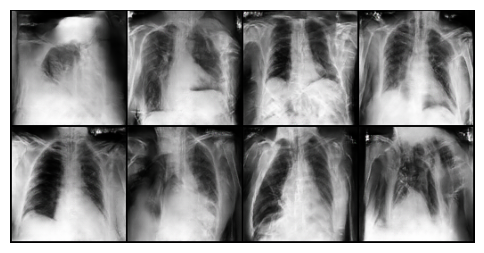

In [32]:
with torch.no_grad():
        sample_z = torch.randn(8, 128, device=device)
        sample_text = torch.randn(8, 512, device=device)  # dummy

        samples = generator(sample_z, sample_text)
        samples = (samples * 0.5) + 0.5   # undo tanh normalization

        grid = make_grid(samples, nrow=4)
        plt.figure(figsize=(6,6))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        plt.show()

#### FID

In [52]:

from torchvision.models import inception_v3, Inception_V3_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained InceptionV3 for FID
weights = Inception_V3_Weights.IMAGENET1K_V1
inception = inception_v3(weights=weights, transform_input=False, aux_logits=True)
inception.fc = nn.Identity()   # so output is 2048-d features, not logits
inception.eval().to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 238MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [53]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

def get_inception_acts(imgs):
    """
    imgs: [B, 3, H, W] in [-1,1]
    returns: [B, 2048] activations
    """
    # [-1,1] -> [0,1]
    imgs = (imgs + 1) / 2

    # Resize to 299x299
    imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)

    # Normalize to ImageNet stats
    imgs = (imgs - IMAGENET_MEAN) / IMAGENET_STD

    with torch.no_grad():
        acts = inception(imgs)   # [B, 2048]
    return acts


In [54]:
# get 1000 real images
def get_acts_real(real_loader, n_samples=1000):
    acts = []
    count = 0
    for batch in real_loader:
        imgs = batch["image_tensor"].to(device)  # [-1,1], [B,3,128,128]
        a = get_inception_acts(imgs)
        acts.append(a.cpu().numpy())
        count += a.size(0)
        if count >= n_samples:
            break
    acts = np.concatenate(acts, axis=0)
    return acts[:n_samples]


In [55]:
# generate 1000 fake images
def get_acts_fake(G, n_samples=1000, batch_size=32, z_dim=128, t_dim=512):
    acts = []
    count = 0
    G.eval()
    with torch.no_grad():
        while count < n_samples:
            curr_bs = min(batch_size, n_samples - count)
            z = torch.randn(curr_bs, z_dim, device=device)
            e_text = torch.randn(curr_bs, t_dim, device=device)  # later: real text enc

            imgs = G(z, e_text)  # [-1,1]
            a = get_inception_acts(imgs)
            acts.append(a.cpu().numpy())
            count += curr_bs
    acts = np.concatenate(acts, axis=0)
    return acts[:n_samples]


In [58]:
from scipy import linalg

# get mean and sd
def compute_mu_sigma(acts):
    mu = np.mean(acts, axis=0)
    sigma = np.cov(acts, rowvar=False)
    return mu, sigma
# calculate fid
def fid_from_acts(acts_r, acts_f):
    mu_r, sig_r = compute_mu_sigma(acts_r)
    mu_f, sig_f = compute_mu_sigma(acts_f)

    diff = mu_r - mu_f
    covmean, _ = linalg.sqrtm(sig_r.dot(sig_f), disp=False)

    # numerical issues: imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sig_r + sig_f - 2 * covmean)
    return float(fid)


In [59]:
# use 1000 real and 1000 fake images
n_samples = 1000
# get images
acts_real = get_acts_real(val_ganloader, n_samples=n_samples)
acts_fake = get_acts_fake(generator, n_samples=n_samples, batch_size=32)
# calculate fid between
fid_score = fid_from_acts(acts_real, acts_fake)
print("FID:", fid_score)


/tmp/ipython-input-2881075845.py:14: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sig_r.dot(sig_f), disp=False)


FID: 137.77783117020317
